<a href="https://colab.research.google.com/github/Anshuman-37/Summer_Dissertation/blob/main/Summer_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prerequisites 

In [ ]:
# Upload the zip file and then unzip it
# unzipping the file in the directory 
!unzip /content/Raw\ Files.zip -d /content/
!unzip /content/Baseline.zip -d /content/

### Installing Libraries

In [3]:
# Install nibabel
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing Files 

In [4]:
## importing libraries 
import os
import re
import nibabel as nib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import torch


### Code

### Reading the Data

##### Getting path of data

In [5]:
## Go in to the directories
## Extracting only important data using Regex
path = '/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/'
regex = re.compile(r'__MPR.*') ; fileRegex1 = re.compile(r'(WIP)*T13D'); mri_data_path = []; 

# Iterating over Directories 
for subdir, dirs, files in os.walk(path):
    for file in files:
        # Storing the path of Data
        if regex.search(file) == None:
            if fileRegex1.search(file): mri_data_path.append(os.path.join(subdir, file));

# Printing the path of Data
for i in mri_data_path: print(i);

/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1327832 dicom/__WIP_MPRAGE_T13D_SENSE_20160222133236_301.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1320961 dicom/__WIP_MPRAGE_T13D_SENSE_20160115152740_301.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1289317 dicom/__WIP_MPRAGE_T13D_SENSE_20150710135121_401.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1277547 dicom/__WIP_MPRAGE_T13D_SENSE_20150430160250_401.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1335478 dicom/__WIP_MPRAGE_T13D_SENSE_20160407112645_401.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1291194 dicom/__WIP_MPRAGE_T13D_SENSE_20150724132211_401.nii


##### Loading data using nibabel

In [6]:
mri_images = []

# Loading data in the image vector
for i in mri_data_path: mri_images.append(nib.load(i)); 

# Printing the shape of images stored and its data type
for i in mri_images: print('Image shape ->',i.shape,end = '\t'); print('Image Data Type ->',i.get_data_dtype());

Image shape -> (288, 288, 180)	Image Data Type -> int16
Image shape -> (288, 288, 180)	Image Data Type -> int16
Image shape -> (288, 288, 180)	Image Data Type -> int16
Image shape -> (288, 288, 180)	Image Data Type -> int16
Image shape -> (288, 288, 180)	Image Data Type -> int16
Image shape -> (288, 288, 180)	Image Data Type -> int16


###### Discussions -

1. - The Data that is loaded right now is our X(Attribute) and Y should be our ASL Measured Data
2. - The nii files are a 3D tensor with some values ranging between 0-400k (IDK what it is but we need to ask her in the next meeting)


###### Things we do next -
1. - Try to normalize the Values of X first
2. - Understanding Y (ASL data) is next
3. - We write a model for using X to predict Y



###### Data Analysis 

In [7]:
## Reading the Data
img = mri_images[0]
a = np.array(img.dataobj)[:,:,np.newaxis,:] # Dimensions we want -> Batch Size x Time x Channels x Height x Width
# Dimensions we have - > Hight x Width x Channels x Time 
## Use to check whether there is anything there or not
print(type(a), a.shape)
# Getting maximum values from the np array
a_max = np.amax(a); a_min = np.amin(a);
print(a_max); print(a_min);  # To ask where this maximum value comming from

<class 'numpy.ndarray'> (288, 288, 1, 180)
287023.0859375
0.0


In [8]:
# # Just checking the time taken to iterate over
# %timeit np.amin(a); 
# %timeit np.amax(a); 

100 loops, best of 5: 11.9 ms per loop
100 loops, best of 5: 11.9 ms per loop


In [8]:
## Min max noramalization
a = (a - a.min()) / (a.max() - a.min())

## Printing to check whether the data has been normalized or not
print(a[120,200,0,1])

0.0


##### Plots of MRI Data 


In [ ]:
## To iterate over the MRI scan slices
for i in range(0,180):
    plt.imshow(a[:,:,0,i],cmap = 'gray')
    plt.show()

## To create the animation of the MRI images
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# img = [] # some array of images
# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(0,179):
#     #frames.append([plt.imshow((a[:,:,i]-a[:,:,i+1])**2, cmap=cm.Greys_r,animated=True)])
#     frames.append([plt.imshow((a[:,:,i], cmap=cm.Greys_r,animated=True)])
# ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
# ani.save('movie.mp4')

In [ ]:
# Normalized
a_max = np.amax(a); a_min = np.amin(a);
print(a_max); print(a_min);

# Unique counts 
unique, counts = np.unique(a, return_counts=True)
freq_counts = np.vstack(( unique, counts)).T
print(freq_counts)

## Uncomment to plot the graph
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(unique,counts)
# # Most of the normalized values lies at less than <0.40 of maximum 
# # There is a lot of data imbalance  
# plt.show()



###### Discussions -

1. - There is a huge unique data imbalance most of the values after noramzalization are below 40% of maximum value.

2. - The data MRI data is kind of Time Series Data so we added one more dimension as channels and used time slices as the 4th dimension

###### Things we do next -
1. - Load Y
2. - Understanding Y ASL data
3. - Normalizing Y

###### Reading the Target Data (ASL)

In [17]:
# Getting the path for ASL files
asl_path = '/content/Baseline/'
asl_data_path = []

# Iterating over directories
for subdir, dirs, files in os.walk(asl_path):
    # Selecting the ASL file
    for file in files:
        if file == 'perfusion_calib.hdr': asl_data_path.append(os.path.join(subdir, file));

# Printing the path of ASL images
for i in asl_data_path: print(i);


/content/Baseline/1259089 dicom/sub0001/oxasl/native_space/perfusion_calib.hdr
/content/Baseline/1327832 dicom/analysis/oxasl_distcorr/native_space/perfusion_calib.hdr
/content/Baseline/1327832 dicom/analysis/oxasl/native_space/perfusion_calib.hdr
/content/Baseline/1320961 dicom/analysis/oxasl/native_space/perfusion_calib.hdr
/content/Baseline/1289317 dicom/analysis/oxasl_distcorr/native_space/perfusion_calib.hdr
/content/Baseline/1289317 dicom/analysis/oxasl/native_space/perfusion_calib.hdr
/content/Baseline/1277547 dicom/analysis/oxasl_distcorr/native_space/perfusion_calib.hdr
/content/Baseline/1277547 dicom/analysis/oxasl/native_space/perfusion_calib.hdr
/content/Baseline/1291194 dicom/analysis/oxasl_distcorr/native_space/perfusion_calib.hdr
/content/Baseline/1291194 dicom/analysis/oxasl/native_space/perfusion_calib.hdr


In [16]:
asl_images = []

# Regex for the asl image
asl_regex = re.compile(r'oxasl_dist.*') 

for i in asl_data_path: 
    if asl_regex.search(i): asl_images.append(nib.load(i)); #print(i); #asl_images.append(nib.load(i)); 
# # Loading data in the image vector
# for i in asl_data_path: asl_images.append(nib.load(i)); 

# # Printing the shape of images stored and its data type
for i in asl_images: print('Image shape ->',i.shape,end = '\t'); print('Image Data Type ->',i.get_data_dtype());


Image shape -> (80, 80, 13)	Image Data Type -> float32
Image shape -> (80, 80, 13)	Image Data Type -> float32
Image shape -> (80, 80, 13)	Image Data Type -> float32
Image shape -> (80, 80, 13)	Image Data Type -> float32


##### EDA and Normalization of ASL DATA

1063438.9997558594
0.0


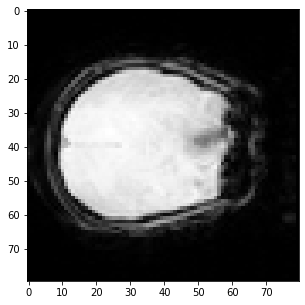

In [49]:
## Reading the Data
img = asl_images[0]
a = np.array(img.dataobj) # Dimensions -  Batch Size x Time x Channels x Height x Width
# Dimensions we have - Height x Width x Part of Brain x Time(ASL) 
## Use to check whether there is anything there or not


# Getting maximum values from the np array
a_max = np.amax(a); a_min = np.amin(a);
print(a_max); print(a_min); 

# # To iterate over the time series data of the ASL data for a specific slice of brain 
# for i in range(0,59):
#     #plt.imshow(a[:,:,4,i],cmap = 'gray')
#     plt.imshow((a[:,:,4,i]-a[:,:,4,i+1])**2,cmap = 'gray')
#     plt.show()

# To create the animation of the ASL images
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(0,59):
    ## For L2 Distance
    frames.append([plt.imshow(a[:,:,4,i], cmap=cm.Greys_r,animated=True)])
    ## For Normal Image
    #frames.append([plt.imshow((a[:,:,i], cmap=cm.Greys_r,animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)
ani.save('movie.mp4')

In [30]:
# Just checking the time taken to iterate over
%timeit np.amin(a); 
%timeit np.amax(a); 

100 loops, best of 5: 1.73 ms per loop
1000 loops, best of 5: 1.86 ms per loop


In [37]:
## Min max noramalization
a[:,:,:,:] = (a - a.min()) / (a.max() - a.min())

In [38]:
# Normalized
a_max = np.amax(a); a_min = np.amin(a);
print(a_max); print(a_min);

# Unique counts 
unique, counts = np.unique(a, return_counts=True)
freq_counts = np.vstack(( unique, counts)).T
print(freq_counts)


# # Uncomment to plot the graph
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(unique,counts)
# # Most of the normalized values lies at less than <0.40 of maximum 
# # There is a lot of data imbalance  
# plt.show()

1.0
0.0
[[0.00000000e+00 8.40625000e+05]
 [9.22509225e-04 5.49038000e+05]
 [1.84501845e-03 3.28383000e+05]
 ...
 [9.98154982e-01 1.00000000e+00]
 [9.99077491e-01 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00]]


###### Discussions -

1. - The values of ASL are kind of similar after the min max normalization. This means we can train a model and get good results. 

2. - The ASL data has 60 images for a specific part of brain which is divided in 13 parts. i.e. in MRI data brain had a sequentail scan which was in 180 parts but in ASL data the sequential scan is reduced to 13 parts. Thus now we know what these dimensions mean in the data.

###### Things we do next -
1. - Try to make the data a bit more better 
2. - Understanding X and Y even better
3. - Trying to make things a notch simpler

##### Making Training and Testing data

###### Creating DATA dicts

In [18]:
print('MRI DATA DICT \t \n','-'*50);
### Data hashmaps - 
### Mri Data  ## Idea - Patient number(key) - Path Stored(value)
mri_map = {};

## Iterating over the mri data's path
for i in mri_data_path:
    ## Value is our path i.e. stored and key is the patient number
    value = i; key = i.split('/')[4].split(' ')[0]; mri_map[key] = value;

# Printing the mri_data_dict 
for k,v in mri_map.items(): print(k,'->',v);

######
print('\nASL DATA DICT - \t \n','-'*50);
######
### ASL Data ## Idea - Patient number(key) - Path Stored(value)
asl_map = {}

## Iterating over the mri data's path
for i in asl_data_path:
    ## Value is our path i.e. stored and key is the patient number
    value = i; key = i.split('/')[3].split(' ')[0]; asl_map[key] = value;

# Printing the asl_data_dict 
for k,v in asl_map.items(): print(k,'->',v);

MRI DATA DICT 	 
 --------------------------------------------------
1327832 -> /content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1327832 dicom/__WIP_MPRAGE_T13D_SENSE_20160222133236_301.nii
1320961 -> /content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1320961 dicom/__WIP_MPRAGE_T13D_SENSE_20160115152740_301.nii
1289317 -> /content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1289317 dicom/__WIP_MPRAGE_T13D_SENSE_20150710135121_401.nii
1277547 -> /content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1277547 dicom/__WIP_MPRAGE_T13D_SENSE_20150430160250_401.nii
1335478 -> /content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1335478 dicom/__WIP_MPRAGE_T13D_SENSE_20160407112645_401.nii
1291194 -> /content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1291194 dicom/__WIP_MPRAGE_T13D_SENSE_20150724132211_401.nii

ASL DATA DICT - 	 
 --------------------------------------------------
1259089 -> /content/Baseline/1259089 dicom/sub0001/oxasl/native_space/perfusion_calib.hdr
1327832

##### Making Training Data X,Y

In [52]:
## Lists to get train x and train y differently
train_x = [] ; train_y = []; 

### Traversing over the map and getting the values for which asl data is present
for k,v in mri_map.items():
    if k in asl_map: train_x.append(v); train_y.append(asl_map[k]);

## Printing train_x and train_y to get path stored
for i in train_x: print(i); 
for i in train_y: print(i);

/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1291194 dicom/__WIP_MPRAGE_T13D_SENSE_20150724132211_401.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1277547 dicom/__WIP_MPRAGE_T13D_SENSE_20150430160250_401.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1289317 dicom/__WIP_MPRAGE_T13D_SENSE_20150710135121_401.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1327832 dicom/__WIP_MPRAGE_T13D_SENSE_20160222133236_301.nii
/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/1320961 dicom/__WIP_MPRAGE_T13D_SENSE_20160115152740_301.nii
/content/Baseline/1291194 dicom/analysis/asldata.nii
/content/Baseline/1277547 dicom/analysis/asldata.nii
/content/Baseline/1289317 dicom/analysis/asldata.nii
/content/Baseline/1327832 dicom/analysis/asldata.nii
/content/Baseline/1320961 dicom/analysis/asldata.nii


#### Model Tensorflow

#### Model Pytorch

In [ ]:

## Defining the model in torch
class Unet_3D(torch.nn.Module):
    ## Intializing the constructor
    def __init__(self):

        super(Unet_3D, self).__init__()
        ### Adding layers
        self.conv1 = torch.nn.Conv3d(180, 160 ,(3,3,3))
        self.activation = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv3d(160,80,(3,3,3))
        self.softmax = torch.nn.ReLU() 
        self.linear = torch.nn.Linear()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

Unet = Unet_3D()